<a href="https://colab.research.google.com/github/RefineX/Change-Detection/blob/main/AML_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For this notebook, download LEVIRCD_Plus-512-256 and WHU-512-256 using the Data Downloader cell below

In [34]:
#@title Data Downloader
dataset = "LEVIRCD_Plus" #@param ["S2Looking", "LEVIRCD_Plus", "WHU"]
resize = "512" #@param ["1024", "512", "256"]
crop = "256" #@param ["1024", "512", "256"]

data_link_dict = {
    'S2Looking': {
      '1024_512': "1-0_vcODMYmyYIY_uhMcs97aAk2OJVduq&confirm=t",
      '1024_256': "1-0mVd6BjKnG3LXhYkbyxdx0-dtRKY6KO&confirm=t",
      '512_512': "1-6WOmE0LTJ4Z31EphmA0L8QY5NMMllsT&confirm=t",
      '512_256': "1-7NSOmHTsDpkEtbgt_N4VSgipCo5kr3a&confirm=t",
      '256_256': "1-8x5d5DrNsgJ5eAOYyKwi91g8knGeRjQ&confirm=t",
      '1024_1024': "1GzrgMwJKguXSWSfFsBSC2qSr52fVEc7W&confirm=t"
    },
    'LEVIRCD_Plus': {
      '1024_512': "1-22GjfF8mlLFNyoJaa6_GMJRfTCoGZyc&confirm=t",
      '1024_256': "1-2r-zCCfQjLRtwwXMGPYAxEJcTS8Hp80&confirm=t",
      '512_512': "1-43scZrxe3Q_PH2EnBRuc_6l9O9WjPs2&confirm=t",
      '512_256': "1-5oC0xV36S4K5VMiQuwheWoyMt1ymYb9&confirm=t",
      '256_256': "1-69cdgqlcXunt5vrCR9jRvcMkpPNzYWr&confirm=t",
      '1024_1024': "1nyPJZGGOL7o8A0m0rGw7wyu2BFIxC4SD&confirm=t"
    },
    'WHU': {
      '1024_512': "1-22GjfF8mlLFNyoJaa6_GMJRfTCoGZyc&confirm=t",
      '1024_256': "1aLl-squfjxvQhpqs0Y7Xz8eMwC2Vrttw&confirm=t",
      '512_512': "1-43scZrxe3Q_PH2EnBRuc_6l9O9WjPs2&confirm=t",
      '512_256': "10ui3sAPdOmCcrJO5cVjFEakMf5W8lwt6&confirm=t",
      '256_256': "1xFRwJJvLjpUsEVQVHkxCulP4Ts92OABM&confirm=t",
      '1024_1024': "1nyPJZGGOL7o8A0m0rGw7wyu2BFIxC4SD&confirm=t"
    }
}

import os
if os.path.exists(f'Data/{dataset}/{resize}_{crop}'):
  print('This dataset already exists.')
else:
  gdown_link = data_link_dict[dataset][f'{resize}_{crop}']
  !gdown "{gdown_link}"
  print('Unzipping...',end='')
  !unzip -q "{resize}_{crop}.zip"
  print('Done.\nDeleting zip...',end='')
  !rm "{resize}_{crop}.zip"
  print('Done.')

Downloading...
From: https://drive.google.com/uc?id=1-5oC0xV36S4K5VMiQuwheWoyMt1ymYb9&confirm=t
To: /content/512_256.zip
100% 317M/317M [00:05<00:00, 53.2MB/s]
Unzipping...Done.
Deleting zip...Done.


In [33]:
# Import libraries
import tensorflow as tf
import os
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
import cv2
import pywt
from tensorflow.keras.models import load_model
import random
import shutil as sh

# Metrics

def iou(y_true,y_pred):
  y_pred = tf.argmax(y_pred,-1)
  y_true = tf.argmax(y_true,-1)
  tp = tf.cast(tf.reduce_sum(y_pred*y_true,axis=[1,2]), 'float32')
  fp = tf.cast(tf.reduce_sum(y_pred*(1-y_true),axis=[1,2]), 'float32')
  fn = tf.cast(tf.reduce_sum((1-y_pred)*y_true,axis=[1,2]), 'float32')
  iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)
  return tf.reduce_mean(iou_value)

def miou(y_true,y_pred):
  y_pred = tf.argmax(y_pred,-1)
  y_true = tf.argmax(y_true,-1)
  tp = tf.cast(tf.reduce_sum(y_pred*y_true,axis=[1,2]), 'float32')
  tn = tf.cast(tf.reduce_sum((1-y_pred)*(1-y_true),axis=[1,2]), 'float32')
  fp = tf.cast(tf.reduce_sum(y_pred*(1-y_true),axis=[1,2]), 'float32')
  fn = tf.cast(tf.reduce_sum((1-y_pred)*y_true,axis=[1,2]), 'float32')
  iou1 = (tp + 1e-14) / (tp + fp + fn + 1e-14)
  iou2 = (tn + 1e-14) / (tn + fp + fn + 1e-14)
  iou_value = (iou1 + iou2) / 2
  return tf.reduce_mean(iou_value)

# Losses

# Phase I: Initial Model Selection

In [ ]:
# Dataset Characteristics
dataset = "LEVIRCD_Plus" #@param ["S2Looking", "LEVIRCD_Plus", "WHU"]
resized_size = "512" #@param [1024, 512, 256]
crop_size = "256" #@param [1024, 512, 256]
resized_size = int(resized_size)
crop_size = int(crop_size)
if dataset == 'S2Looking':
  pre_image = 'Image1'
  post_image = 'Image2'
elif dataset == 'LEVIRCD_Plus':
  pre_image = 'A'
  post_image = 'B'
label_image = 'label'
PATH = f"/content/Data/{dataset}/{resized_size}_{crop_size}"
Path('saved/models/').mkdir(parents=True, exist_ok=True)
Path('saved/histories/').mkdir(parents=True, exist_ok=True)

In [ ]:
# Downloading FC-EF, Siam-Conc, Siam-Diff
!gdown "1QwvuA0Bn0wwiJ3ZnWOYsQw7PJfLQCFWh&confirm=t"
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
!gdown "1giNzvtpW_DvlbmaE8PTCJ5jmMHM3vBHB&confirm=t"
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_siamconc_0.5361.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_siamconc_0.5361.zip
!gdown "1K7M1zOqEH-yCBSJO2gS8EKmRyW1vu8OY&confirm=t"
!unzip /content/LEVIRCD_Plus_resnet18_model_siamdiff_0.5080.zip
!rm /content/LEVIRCD_Plus_resnet18_model_siamdiff_0.5080.zip

In [ ]:
# FC-EF
def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]

  imageA = tf.cast(imageA,tf.float32)
  imageB = tf.cast(imageB,tf.float32)
  image = tf.concat([imageA,imageB],axis=-1)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return image, label

def normalize(image, label):
  image = image / 255
  label = label / 255
  return image, label

def load_image(image_file):
  image, label = load(image_file)
  image, label = normalize(image, label)
  return image, label

BATCH_SIZE = 16
test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)

print(f'test_dataset_length: {test_dataset_length}')

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Model #1 IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

test_dataset_length: 87
87/87 [==============================] - 11s 113ms/step - loss: 0.0767 - iou: 0.5502 - accuracy: 0.9754
Model #1 IoU = 55.02%


In [ ]:
# Siam-Conc, Siam-Diff
def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]

  imageA = tf.cast(imageA,tf.float32)
  imageB = tf.cast(imageB,tf.float32)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return imageA, imageB, label

def normalize(imageA, imageB, label):
  imageA = imageA / 255
  imageB = imageB / 255
  label = label / 255
  return imageA, imageB, label

def load_image(image_file):
  imageA, imageB, label = load(image_file)
  imageA, imageB, label = normalize(imageA, imageB, label)
  return (imageA, imageB), label

test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)

print(f'test_dataset_length: {test_dataset_length}')

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_siamconc_0.5361.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Model #2 IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_siamdiff_0.5080.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Model #3 IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

test_dataset_length: 87
87/87 [==============================] - 8s 70ms/step - loss: 0.0676 - iou: 0.5361 - accuracy: 0.9795
Model #2 IoU = 53.61%
87/87 [==============================] - 7s 73ms/step - loss: 0.0620 - iou: 0.5080 - accuracy: 0.9787
Model #3 IoU = 50.80%


# Phase II: Results

## Original Dataset

In [35]:
# Dataset Characteristics
dataset = "LEVIRCD_Plus" #@param ["S2Looking", "LEVIRCD_Plus", "WHU"]
resized_size = "512" #@param [1024, 512, 256]
crop_size = "256" #@param [1024, 512, 256]
resized_size = int(resized_size)
crop_size = int(crop_size)
if dataset == 'S2Looking':
  pre_image = 'Image1'
  post_image = 'Image2'
elif dataset == 'LEVIRCD_Plus':
  pre_image = 'A'
  post_image = 'B'
label_image = 'label'
PATH = f"/content/Data/{dataset}/{resized_size}_{crop_size}"
Path('saved/models/').mkdir(parents=True, exist_ok=True)
Path('saved/histories/').mkdir(parents=True, exist_ok=True)

In [ ]:
# Downloading Unaugmented, Canny, Haar and Feature augmented models
!gdown "1QwvuA0Bn0wwiJ3ZnWOYsQw7PJfLQCFWh&confirm=t"
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
!gdown "1UduV1ATCjnPHfMfgL8V4wINQvSJyqEeD&confirm=t"
!unzip /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
!rm /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
!gdown "1eOeFpU2Fl4Ekn0ytqjMLVP4CuMP8xl-M&confirm=t"
!unzip /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
!rm /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
!gdown "1W1aHBDWZ7SxneZx11UcTUH_59b9FEqT1&confirm=t"
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip

In [ ]:
# Select augmentation type in the cell below corresponding to the model you want to test

In [39]:
#@title Select Augmentation type
augmentation = "edge_augmented" #@param ["none", "edge_augmented", "mra_augmented", "feature_augmented"]

# Edge Augmentation
def canny_edge(image):
  l,u = 100, 200
  edgesA = cv2.Canny(image[:,:,:3].numpy()[:,:,::-1], l, u)
  edgesB = cv2.Canny(image[:,:,3:].numpy()[:,:,::-1], l, u)
  edges = tf.stack([edgesA,edgesB],axis=-1)
  edges = tf.cast(edges,tf.float32)
  edges /= tf.reduce_max(edges)
  return edges

# MRA Augmentation
def mra_haar(image):

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,:3].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dA = decomp[1][0]
  h_dA = (h_dA-h_dA.min())/(h_dA.max()-h_dA.min())
  h_dA = cv2.resize(h_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dA = decomp[1][1]
  v_dA = (v_dA-v_dA.min())/(v_dA.max()-v_dA.min())
  v_dA = cv2.resize(v_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dA = decomp[1][2]
  d_dA = (d_dA-d_dA.min())/(d_dA.max()-d_dA.min())
  d_dA = cv2.resize(d_dA, (crop_size,crop_size), cv2.INTER_LINEAR)

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,3:].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dB = decomp[1][0]
  h_dB = (h_dB-h_dB.min())/(h_dB.max()-h_dB.min())
  h_dB = cv2.resize(h_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dB = decomp[1][1]
  v_dB = (v_dB-v_dB.min())/(v_dB.max()-v_dB.min())
  v_dB = cv2.resize(v_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dB = decomp[1][2]
  d_dB = (d_dB-d_dB.min())/(d_dB.max()-d_dB.min())
  d_dB = cv2.resize(d_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  edges = tf.stack([h_dA, v_dA, d_dA, h_dB, v_dB, d_dB],axis=-1)
  edges = tf.cast(edges,tf.float32)

  return edges

def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]

  image = tf.concat([imageA,imageB],axis=-1)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return image, label

def normalize(image, label):
  image = image / 255
  label = label / 255
  return image, label

def load_image(image_file):
  image, label = load(image_file)
  if augmentation == 'edge_augmented':
    edges = tf.py_function(canny_edge, [image], tf.float32)
  elif augmentation == 'mra_augmented':
    edges = tf.py_function(mra_haar, [image], tf.float32)
  image = tf.cast(image,tf.float32)
  image, label = normalize(image, label)
  if augmentation == 'edge_augmented' or augmentation == 'mra_augmented':
    image = tf.concat([image,edges],axis=-1)
  return image, label

BATCH_SIZE = 16
test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)

print(f'test_dataset_length: {test_dataset_length}')

test_dataset_length: 87


### LEVIRCD Plus

In [38]:
# Unaugmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Unaugmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 7s 72ms/step - loss: 0.0767 - iou: 0.5502 - accuracy: 0.9754
Unaugmented Model IoU = 55.02%


In [40]:
# Edge Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Edge Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 28s 299ms/step - loss: 0.0687 - iou: 0.5714 - accuracy: 0.9810
Edge Augmented Model IoU = 57.14%


In [ ]:
# MRA Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'MRA Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 27s 307ms/step - loss: 0.0647 - iou: 0.5604 - accuracy: 0.9783
MRA Augmented Model IoU = 56.04%


In [ ]:
# Feature Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Feature Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 7s 70ms/step - loss: 0.0798 - iou: 0.5535 - accuracy: 0.9763
Feature Augmented Model IoU = 55.35%


# Phase III: Results

## Dataset Shift

In [ ]:
# Downloading Unaugmented, Canny, Haar and Feature augmented models
!gdown "1QwvuA0Bn0wwiJ3ZnWOYsQw7PJfLQCFWh&confirm=t"
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
!gdown "1UduV1ATCjnPHfMfgL8V4wINQvSJyqEeD&confirm=t"
!unzip /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
!rm /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
!gdown "1eOeFpU2Fl4Ekn0ytqjMLVP4CuMP8xl-M&confirm=t"
!unzip /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
!rm /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
!gdown "16qjB2EIqrIow6sPOSPczesu2MP-1KDBQ&confirm=t"
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip

In [43]:
# Dataset Characteristics
dataset = "WHU" #@param ["S2Looking", "LEVIRCD_Plus","WHU"]
resized_size = "512" #@param [1024, 512, 256]
crop_size = "256" #@param [1024, 512, 256]
resized_size = int(resized_size)
crop_size = int(crop_size)
if dataset == 'S2Looking':
  pre_image = 'Image1'
  post_image = 'Image2'
elif dataset == 'LEVIRCD_Plus':
  pre_image = 'A'
  post_image = 'B'
elif dataset == 'WHU':
  pre_image = 'B'
  post_image = 'A'
label_image = 'label'
PATH = f"/content/Data/{dataset}/{resized_size}_{crop_size}"
Path('saved/models/').mkdir(parents=True, exist_ok=True)
Path('saved/histories/').mkdir(parents=True, exist_ok=True)

In [ ]:
# Select augmentation type in the cell below corresponding to the model you want to test

In [46]:
#@title Select Augmentation type
augmentation = "edge_augmented" #@param ["none", "edge_augmented", "mra_augmented", "feature_augmented"]

# Helper Functions for Model #1

# Edge Augmentation
def canny_edge(image):
  l,u = 100, 200
  edgesA = cv2.Canny(image[:,:,:3].numpy()[:,:,::-1], l, u)
  edgesB = cv2.Canny(image[:,:,3:].numpy()[:,:,::-1], l, u)
  edges = tf.stack([edgesA,edgesB],axis=-1)
  edges = tf.cast(edges,tf.float32)
  edges /= tf.reduce_max(edges)
  return edges

# MRA Augmentation
def mra_haar(image):

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,:3].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dA = decomp[1][0]
  h_dA = (h_dA-h_dA.min())/(h_dA.max()-h_dA.min())
  h_dA = cv2.resize(h_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dA = decomp[1][1]
  v_dA = (v_dA-v_dA.min())/(v_dA.max()-v_dA.min())
  v_dA = cv2.resize(v_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dA = decomp[1][2]
  d_dA = (d_dA-d_dA.min())/(d_dA.max()-d_dA.min())
  d_dA = cv2.resize(d_dA, (crop_size,crop_size), cv2.INTER_LINEAR)

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,3:].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dB = decomp[1][0]
  h_dB = (h_dB-h_dB.min())/(h_dB.max()-h_dB.min())
  h_dB = cv2.resize(h_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dB = decomp[1][1]
  v_dB = (v_dB-v_dB.min())/(v_dB.max()-v_dB.min())
  v_dB = cv2.resize(v_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dB = decomp[1][2]
  d_dB = (d_dB-d_dB.min())/(d_dB.max()-d_dB.min())
  d_dB = cv2.resize(d_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  edges = tf.stack([h_dA, v_dA, d_dA, h_dB, v_dB, d_dB],axis=-1)
  edges = tf.cast(edges,tf.float32)

  return edges

def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]
  
  image = tf.concat([imageA,imageB],axis=-1)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return image, label

def normalize(image, label):
  image = image / 255
  label = label / 255
  return image, label

def load_image(image_file):
  image, label = load(image_file)
  if augmentation == 'edge_augmented':
    edges = tf.py_function(canny_edge, [image], tf.float32)
  elif augmentation == 'mra_augmented':
    edges = tf.py_function(mra_haar, [image], tf.float32)
  image = tf.cast(image,tf.float32)
  image, label = normalize(image, label)
  if augmentation == 'edge_augmented' or augmentation == 'mra_augmented':
    image = tf.concat([image,edges],axis=-1)
  return image, label

BATCH_SIZE = 1

test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)

print(f'test_dataset_length: {test_dataset_length}')

test_dataset_length: 364


### WHU

In [45]:
# Unaugmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Unaugmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

364/364 [==============================] - 7s 15ms/step - loss: 0.4561 - iou: 0.3530 - accuracy: 0.9018
Unaugmented Model IoU = 35.30%


In [47]:
# Edge Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Edge Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

364/364 [==============================] - 8s 21ms/step - loss: 0.7186 - iou: 0.3862 - accuracy: 0.9022
Edge Augmented Model IoU = 38.62%


In [32]:
# MRA Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'MRA Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

364/364 [==============================] - 10s 26ms/step - loss: 0.6894 - iou: 0.3567 - accuracy: 0.9033
MRA Augmented Model IoU = 35.67%


In [23]:
# Feature Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Feature Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

364/364 [==============================] - 6s 12ms/step - loss: 0.6802 - iou: 0.3661 - accuracy: 0.9014
Feature Augmented Model IoU = 36.61%


## Few-Shot Learning

In [ ]:
# Downloading few-shot trained models
!gdown "1w96LaZj3P5XFTreI2bfDSZmeDa7WtjiE&confirm=t"
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_subset_50_unaug_0.4999.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_subset_50_unaug_0.4999.zip
!gdown "1Dq83-Hr-YSMwJli2whCawE3_UUYwoQUK&confirm=t"
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_subset_25_unaug_0.4568.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_subset_25_unaug_0.4568.zip

!gdown "1EPoSn8miYs5fTqwpAs6yOVH6QZRJzkk8&confirm=t"
!unzip /content/LEVIRCD_Plus_resnet18_model_ef_canny1_subset_50_0.5409.zip
!rm /content/LEVIRCD_Plus_resnet18_model_ef_canny1_subset_50_0.5409.zip
!gdown "1HN1Y4C8Ixdp3uJiRYtz2pHPa_I_InIni&confirm=t"
!unzip /content/LEVIRCD_Plus_resnet18_model_ef_canny1_subset_25_0.4862.zip
!rm /content/LEVIRCD_Plus_resnet18_model_ef_canny1_subset_25_0.4862.zip

!gdown "1lhhFVv4OewW-aUaHPHej_fWYV5hIUMnd&confirm=t"
!unzip /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_subset_50_0.5446.zip
!rm /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_subset_50_0.5446.zip
!gdown "1p4no4ktOXXCB4e_pw1wF9eRFp5ornTSS&confirm=t"
!unzip /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_subset_25_0.4922.zip
!rm /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_subset_25_0.4922.zip

!gdown "1SJ0Nmw4Qa6wGFhZpPDnkvi9-SsFrMBdt&confirm=t"
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_pretrain_imagenet_subset_50_0.3793.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_pretrain_imagenet_subset_50_0.3793.zip
!gdown "1PUmrwCmrj4ZZBo0dRqy21lruq8uUoAB0&confirm=t"
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_subset_25_0.3191.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_subset_25_0.3191.zip

In [ ]:
# Select subset_percent (25/50) for the proportion of dataset to be tested

In [ ]:
# Dataset Characteristics
dataset = "LEVIRCD_Plus" #@param ["S2Looking", "LEVIRCD_Plus","WHU"]
resized_size = "512" #@param [1024, 512, 256]
crop_size = "256" #@param [1024, 512, 256]
resized_size = int(resized_size)
crop_size = int(crop_size)
if dataset == 'S2Looking':
  pre_image = 'Image1'
  post_image = 'Image2'
elif dataset == 'LEVIRCD_Plus':
  pre_image = 'A'
  post_image = 'B'
elif dataset == 'WHU':
  pre_image = 'A'
  post_image = 'B'
label_image = 'label'
PATH = f"/content/Data/{dataset}/{resized_size}_{crop_size}"
Path('saved/models/').mkdir(parents=True, exist_ok=True)
Path('saved/histories/').mkdir(parents=True, exist_ok=True)

# Subset Choice
subset_percent = "25" #@param ["10", "25", "50", "100"]
if subset_percent == "100":
  PATH = PATH
else:
  Subset_PATH = PATH+"_subset_{}".format(subset_percent)
  if not os.path.isdir(Subset_PATH):
    Path(Subset_PATH).mkdir(parents=True, exist_ok=True)
    dirs = os.listdir(PATH)
    subdirs = os.listdir(PATH+"/"+dirs[0])
    for dir in dirs:
      for subdir in subdirs:
        Path(Subset_PATH+"/"+dir+"/"+subdir).mkdir(parents=True, exist_ok=True)

    for dir in dirs:
      img_list = os.listdir(PATH+"/"+dir+"/"+pre_image)
      initial_count = len(img_list)
      final_count = int(initial_count * int(subset_percent)/100)
      random.seed(0)
      subset_img_list = random.sample(img_list, final_count)
      for subdir in subdirs:
        for subset_img in subset_img_list:
          if subdir == label_image:
            source_path = PATH+"/"+dir+"/"+subdir+"/"+subset_img.replace('jpg','png')
            destination_path = Subset_PATH+"/"+dir+"/"+subdir+"/"+subset_img.replace('jpg','png')
          else:
            source_path = PATH+"/"+dir+"/"+subdir+"/"+subset_img
            destination_path = Subset_PATH+"/"+dir+"/"+subdir+"/"+subset_img
          sh.copy(source_path, destination_path)
  PATH = Subset_PATH

In [ ]:
# Select augmentation type in the cell below corresponding to the model you want to test

In [ ]:
#@title Select Augmentation type
augmentation = "none" #@param ["none", "edge_augmented", "mra_augmented", "feature_augmented"]

# Edge Augmentation
def canny_edge(image):
  l,u = 100, 200
  edgesA = cv2.Canny(image[:,:,:3].numpy()[:,:,::-1], l, u)
  edgesB = cv2.Canny(image[:,:,3:].numpy()[:,:,::-1], l, u)
  edges = tf.stack([edgesA,edgesB],axis=-1)
  edges = tf.cast(edges,tf.float32)
  edges /= tf.reduce_max(edges)
  return edges

# MRA Augmentation
def mra_haar(image):

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,:3].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dA = decomp[1][0]
  h_dA = (h_dA-h_dA.min())/(h_dA.max()-h_dA.min())
  h_dA = cv2.resize(h_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dA = decomp[1][1]
  v_dA = (v_dA-v_dA.min())/(v_dA.max()-v_dA.min())
  v_dA = cv2.resize(v_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dA = decomp[1][2]
  d_dA = (d_dA-d_dA.min())/(d_dA.max()-d_dA.min())
  d_dA = cv2.resize(d_dA, (crop_size,crop_size), cv2.INTER_LINEAR)

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,3:].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dB = decomp[1][0]
  h_dB = (h_dB-h_dB.min())/(h_dB.max()-h_dB.min())
  h_dB = cv2.resize(h_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dB = decomp[1][1]
  v_dB = (v_dB-v_dB.min())/(v_dB.max()-v_dB.min())
  v_dB = cv2.resize(v_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dB = decomp[1][2]
  d_dB = (d_dB-d_dB.min())/(d_dB.max()-d_dB.min())
  d_dB = cv2.resize(d_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  edges = tf.stack([h_dA, v_dA, d_dA, h_dB, v_dB, d_dB],axis=-1)
  edges = tf.cast(edges,tf.float32)

  return edges

def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]
  
  image = tf.concat([imageA,imageB],axis=-1)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return image, label

def normalize(image, label):
  image = image / 255
  label = label / 255
  return image, label

def load_image(image_file):
  image, label = load(image_file)
  if augmentation == 'edge_augmented':
    edges = tf.py_function(canny_edge, [image], tf.float32)
  elif augmentation == 'mra_augmented':
    edges = tf.py_function(mra_haar, [image], tf.float32)
  image = tf.cast(image,tf.float32)
  image, label = normalize(image, label)
  if augmentation == 'edge_augmented' or augmentation == 'mra_augmented':
    image = tf.concat([image,edges],axis=-1)
  return image, label

BATCH_SIZE = 1
test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)

print(f'test_dataset_length: {test_dataset_length}')

In [ ]:
# Unaugmented, subset 50
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_subset_50_unaug_0.4999.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'50% Training Set: Unaugmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

696/696 [==============================] - 11s 15ms/step - loss: 0.0751 - iou: 0.5107 - accuracy: 0.9760
50% Training Set: Unaugmented Model IoU = 51.07%


In [ ]:
# Unaugmented, subset 25
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_subset_25_unaug_0.4568.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'25% Training Set: Unaugmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

348/348 [==============================] - 5s 11ms/step - loss: 0.0820 - iou: 0.4777 - accuracy: 0.9707
25% Training Set: Unaugmented Model IoU = 47.77%


In [ ]:
# Edge Augmented, subset 50
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_subset_50_0.5409.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'50% Training Set: Edge Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

696/696 [==============================] - 18s 26ms/step - loss: 0.0676 - iou: 0.5488 - accuracy: 0.9775
50% Training Set: Edge Augmented Model IoU = 54.88%


In [ ]:
# Edge Augmented, subset 25
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_subset_25_0.4862.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'25% Training Set: Edge Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

348/348 [==============================] - 10s 26ms/step - loss: 0.0905 - iou: 0.4875 - accuracy: 0.9719
25% Training Set: Edge Augmented Model IoU = 48.75%


In [ ]:
# MRA Augmented, subset 50
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_subset_50_0.5446.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'50% Training Set: MRA Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

44/44 [==============================] - 14s 300ms/step - loss: 0.0765 - iou: 0.5398 - accuracy: 0.9758
50% Training Set: MRA Augmented Model IoU = 53.98%


In [ ]:
# MRA Augmented, subset 25
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_subset_25_0.4922.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'25% Training Set: MRA Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

348/348 [==============================] - 12s 34ms/step - loss: 0.0929 - iou: 0.4860 - accuracy: 0.9737
25% Training Set: MRA Augmented Model IoU = 48.60%


In [ ]:
# Feature Augmented, subset 50
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_pretrain_imagenet_subset_50_0.3793.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'50% Training Set: Feature Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

696/696 [==============================] - 10s 13ms/step - loss: nan - iou: 0.3506 - accuracy: 0.9582
50% Training Set: Feature Augmented Model IoU = 35.06%


In [ ]:
# Feature Augmented, subset 25
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_subset_25_0.3191.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'25% Training Set: Feature Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

348/348 [==============================] - 5s 12ms/step - loss: nan - iou: 0.3563 - accuracy: 0.9567
25% Training Set: Feature Augmented Model IoU = 35.63%


## Noise robustification

In [ ]:
# Downloading Unaugmented, Canny, Haar and Feature augmented models
!gdown "1QwvuA0Bn0wwiJ3ZnWOYsQw7PJfLQCFWh&confirm=t"
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
!gdown "1UduV1ATCjnPHfMfgL8V4wINQvSJyqEeD&confirm=t"
!unzip /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
!rm /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
!gdown "1eOeFpU2Fl4Ekn0ytqjMLVP4CuMP8xl-M&confirm=t"
!unzip /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
!rm /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
!gdown "1W1aHBDWZ7SxneZx11UcTUH_59b9FEqT1&confirm=t"
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip

In [ ]:
# Dataset Characteristics
dataset = "LEVIRCD_Plus" #@param ["S2Looking", "LEVIRCD_Plus", "WHU"]
resized_size = "512" #@param [1024, 512, 256]
crop_size = "256" #@param [1024, 512, 256]
resized_size = int(resized_size)
crop_size = int(crop_size)
if dataset == 'S2Looking':
  pre_image = 'Image1'
  post_image = 'Image2'
elif dataset == 'LEVIRCD_Plus':
  pre_image = 'A'
  post_image = 'B'
label_image = 'label'
PATH = f"/content/Data/{dataset}/{resized_size}_{crop_size}"
Path('saved/models/').mkdir(parents=True, exist_ok=True)
Path('saved/histories/').mkdir(parents=True, exist_ok=True)

In [ ]:
# Select augmentation and noise type in the cell below corresponding to the model you want to test

In [ ]:
#@title Select Augmentation type
augmentation = "feature_augmented" #@param ["none", "edge_augmented", "mra_augmented", "feature_augmented"]
noise_type = "salt and pepper" #@param ["gaussian", "salt and pepper"]

def salt_and_pepper_noise(image):
  noisy_image = image
  tf.random.set_seed(0)
  uniform_noise = tf.random.uniform((crop_size, crop_size),0,1,seed=0)
  uniform_noise = tf.stack([uniform_noise]*6,axis=-1)
  power = 0.025
  noisy_image = tf.where(uniform_noise < power, tf.zeros_like(noisy_image), noisy_image)
  noisy_image = tf.where(uniform_noise > (1-power), tf.ones_like(noisy_image), noisy_image)
  return noisy_image

def gaussian_noise(image):
  noisy_image = image
  power = 0.2
  tf.random.set_seed(0)
  noisy_image = noisy_image + (tf.random.normal(tf.shape(noisy_image),stddev=0.5,seed=0) * power)
  # ni_max = tf.reduce_max(noisy_image)
  # ni_min = tf.reduce_min(noisy_image)
  noisy_image = tf.clip_by_value(noisy_image, 0, 1)
  # noisy_image = (noisy_image - ni_min) / (ni_max - ni_min)
  return noisy_image

# Edge Augmentation
def canny_edge(image):
  l,u = 100, 200
  edgesA = cv2.Canny(image[:,:,:3].numpy()[:,:,::-1], l, u)
  edgesB = cv2.Canny(image[:,:,3:].numpy()[:,:,::-1], l, u)
  edges = tf.stack([edgesA,edgesB],axis=-1)
  edges = tf.cast(edges,tf.float32)
  edges /= tf.reduce_max(edges)
  return edges

# MRA Augmentation
def mra_haar(image):

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,:3].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dA = decomp[1][0]
  h_dA = (h_dA-h_dA.min())/(h_dA.max()-h_dA.min())
  h_dA = cv2.resize(h_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dA = decomp[1][1]
  v_dA = (v_dA-v_dA.min())/(v_dA.max()-v_dA.min())
  v_dA = cv2.resize(v_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dA = decomp[1][2]
  d_dA = (d_dA-d_dA.min())/(d_dA.max()-d_dA.min())
  d_dA = cv2.resize(d_dA, (crop_size,crop_size), cv2.INTER_LINEAR)

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,3:].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dB = decomp[1][0]
  h_dB = (h_dB-h_dB.min())/(h_dB.max()-h_dB.min())
  h_dB = cv2.resize(h_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dB = decomp[1][1]
  v_dB = (v_dB-v_dB.min())/(v_dB.max()-v_dB.min())
  v_dB = cv2.resize(v_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dB = decomp[1][2]
  d_dB = (d_dB-d_dB.min())/(d_dB.max()-d_dB.min())
  d_dB = cv2.resize(d_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  edges = tf.stack([h_dA, v_dA, d_dA, h_dB, v_dB, d_dB],axis=-1)
  edges = tf.cast(edges,tf.float32)

  return edges

def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]

  imageA = tf.cast(imageA,tf.float32)
  imageB = tf.cast(imageB,tf.float32)
  image = tf.concat([imageA,imageB],axis=-1)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return image, label

def normalize(image, label):
  image = image / 255
  label = label / 255
  return image, label

def load_image(image_file):
  image, label = load(image_file)
  image, label = normalize(image, label)
  if noise_type == 'gaussian':
    # noisy_image = tf.py_function(gaussian_noise, [image], tf.float32)
    noisy_image = gaussian_noise(image)
  elif noise_type == 'salt and pepper':
    noisy_image = salt_and_pepper_noise(image)
    # noisy_image = tf.py_function(salt_and_pepper_noise, [image], tf.float32)
  noisy_image = tf.cast(noisy_image * 255,tf.uint8)
  if augmentation == 'edge_augmented':
    edges = tf.py_function(canny_edge, [noisy_image], tf.float32)
  elif augmentation == 'mra_augmented':
    edges = tf.py_function(mra_haar, [noisy_image], tf.float32)
  noisy_image = tf.cast(noisy_image / 255,tf.float32)
  if augmentation == 'edge_augmented' or augmentation == 'mra_augmented':
    noisy_image = tf.concat([noisy_image,edges],axis=-1)
  return noisy_image, label

BATCH_SIZE = 16
test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)

print(f'test_dataset_length: {test_dataset_length}')

### Gaussian Noise

In [ ]:
# Unaugmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Unaugmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 22s 241ms/step - loss: 0.0829 - iou: 0.4374 - accuracy: 0.9717
Unaugmented Model IoU = 43.74%


In [ ]:
# Edge Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Edge Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 44s 502ms/step - loss: 0.0820 - iou: 0.4549 - accuracy: 0.9751
Edge Augmented Model IoU = 45.49%


In [ ]:
# MRA Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'MRA Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 39s 436ms/step - loss: 0.0749 - iou: 0.5006 - accuracy: 0.9738
MRA Augmented Model IoU = 50.06%


In [ ]:
# Feature Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Feature Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 33s 370ms/step - loss: 0.0826 - iou: 0.4608 - accuracy: 0.9740
Feature Augmented Model IoU = 46.08%


### Salt and Pepper Noise

In [ ]:
# Unaugmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Unaugmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 22s 249ms/step - loss: 0.0883 - iou: 0.4622 - accuracy: 0.9722
Unaugmented Model IoU = 46.22%


In [ ]:
# Edge Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Edge Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 36s 407ms/step - loss: 0.1035 - iou: 0.4706 - accuracy: 0.9735
Edge Augmented Model IoU = 47.06%


In [ ]:
# MRA Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'MRA Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 36s 409ms/step - loss: 0.0846 - iou: 0.5139 - accuracy: 0.9736
MRA Augmented Model IoU = 51.39%


In [ ]:
# Feature Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Feature Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 16s 178ms/step - loss: 0.1402 - iou: 0.4486 - accuracy: 0.9691
Feature Augmented Model IoU = 44.86%


# Dataset examples display

In [ ]:
# Dataset Characteristics
dataset = "LEVIRCD_Plus" #@param ["S2Looking", "LEVIRCD_Plus", "WHU"]
resized_size = "512" #@param [1024, 512, 256]
crop_size = "256" #@param [1024, 512, 256]
resized_size = int(resized_size)
crop_size = int(crop_size)
if dataset == 'S2Looking':
  pre_image = 'Image1'
  post_image = 'Image2'
elif dataset == 'LEVIRCD_Plus':
  pre_image = 'A'
  post_image = 'B'
label_image = 'label'
PATH = f"/content/Data/{dataset}/{resized_size}_{crop_size}"
Path('saved/models/').mkdir(parents=True, exist_ok=True)
Path('saved/histories/').mkdir(parents=True, exist_ok=True)

In [ ]:
#@title Select Augmentation type
augmentation = "mra_augmented" #@param ["none", "edge_augmented", "mra_augmented", "feature_augmented"]

In [ ]:
# Edge Augmentation
def canny_edge(image):
  l,u = 100, 200
  edgesA = cv2.Canny(image[:,:,:3].numpy()[:,:,::-1], l, u)
  edgesB = cv2.Canny(image[:,:,3:].numpy()[:,:,::-1], l, u)
  edges = tf.stack([edgesA,edgesB],axis=-1)
  edges = tf.cast(edges,tf.float32)
  edges /= tf.reduce_max(edges)
  return edges

# MRA Augmentation
def mra_haar(image):

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,:3].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dA = decomp[1][0]
  h_dA = (h_dA-h_dA.min())/(h_dA.max()-h_dA.min())
  h_dA = cv2.resize(h_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dA = decomp[1][1]
  v_dA = (v_dA-v_dA.min())/(v_dA.max()-v_dA.min())
  v_dA = cv2.resize(v_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dA = decomp[1][2]
  d_dA = (d_dA-d_dA.min())/(d_dA.max()-d_dA.min())
  d_dA = cv2.resize(d_dA, (crop_size,crop_size), cv2.INTER_LINEAR)

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,3:].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dB = decomp[1][0]
  h_dB = (h_dB-h_dB.min())/(h_dB.max()-h_dB.min())
  h_dB = cv2.resize(h_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dB = decomp[1][1]
  v_dB = (v_dB-v_dB.min())/(v_dB.max()-v_dB.min())
  v_dB = cv2.resize(v_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dB = decomp[1][2]
  d_dB = (d_dB-d_dB.min())/(d_dB.max()-d_dB.min())
  d_dB = cv2.resize(d_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  edges = tf.stack([h_dA, v_dA, d_dA, h_dB, v_dB, d_dB],axis=-1)
  edges = tf.cast(edges,tf.float32)

  return edges

def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]

  image = tf.concat([imageA,imageB],axis=-1)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return image, label

def normalize(image, label):
  image = image / 255
  label = label / 255
  return image, label

def load_image(image_file):
  image, label = load(image_file)
  if augmentation == 'edge_augmented':
    edges = tf.py_function(canny_edge, [image], tf.float32)
  elif augmentation == 'mra_augmented':
    edges = tf.py_function(mra_haar, [image], tf.float32)
  image = tf.cast(image,tf.float32)
  image, label = normalize(image, label)
  if augmentation == 'edge_augmented' or augmentation == 'mra_augmented':
    image = tf.concat([image,edges],axis=-1)
  return image, label

BATCH_SIZE = 16
test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)

print(f'test_dataset_length: {test_dataset_length}')

test_dataset_length: 87


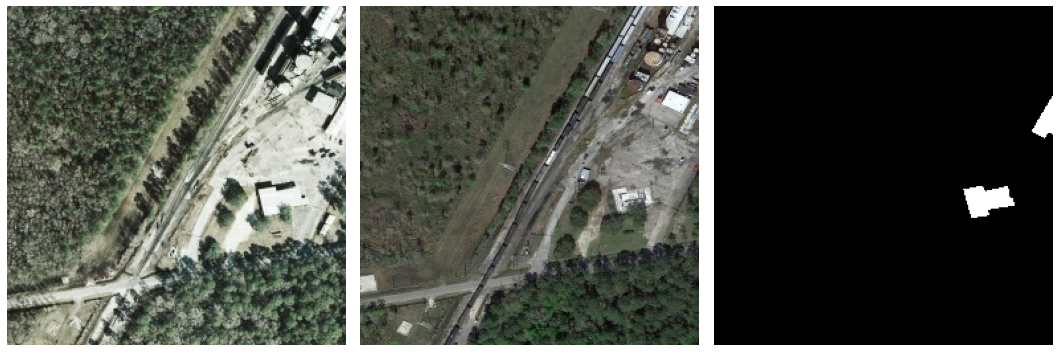

In [ ]:
# Dataset test - unaugmented
for x,y in test_dataset.take(1):
  pass
plt.figure(figsize=(3*5,5))
idx = 0
for i, arr in enumerate([x[idx,:,:,:3].numpy(), x[idx,:,:,3:6].numpy(),y[idx].numpy().argmax(-1)],start=1):
  plt.subplot(1,3,i)
  plt.imshow(arr,cmap='gray')
  plt.axis('off')
  plt.tight_layout()

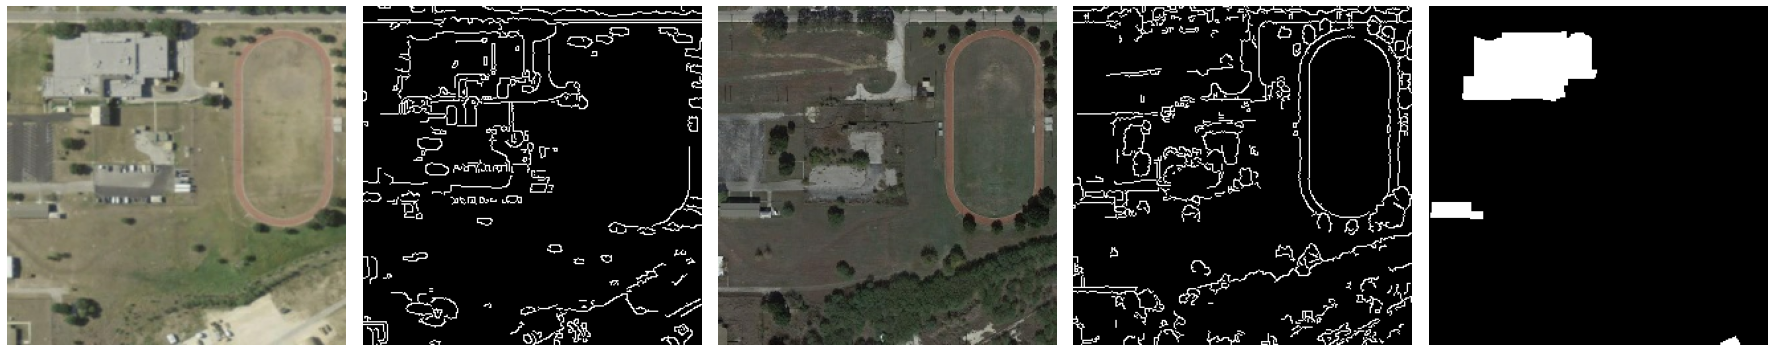

In [ ]:
# Dataset test - edge augmented
for x,y in test_dataset.take(1):
  pass
plt.figure(figsize=(5*5,5))
idx = 0
for i, arr in enumerate([x[idx,:,:,:3].numpy(), x[idx,:,:,6].numpy(), x[idx,:,:,3:6].numpy(), x[idx,:,:,7].numpy(),y[idx].numpy().argmax(-1)],start=1):
  plt.subplot(1,5,i)
  plt.imshow(arr,cmap='gray')
  plt.axis('off')
  plt.tight_layout()

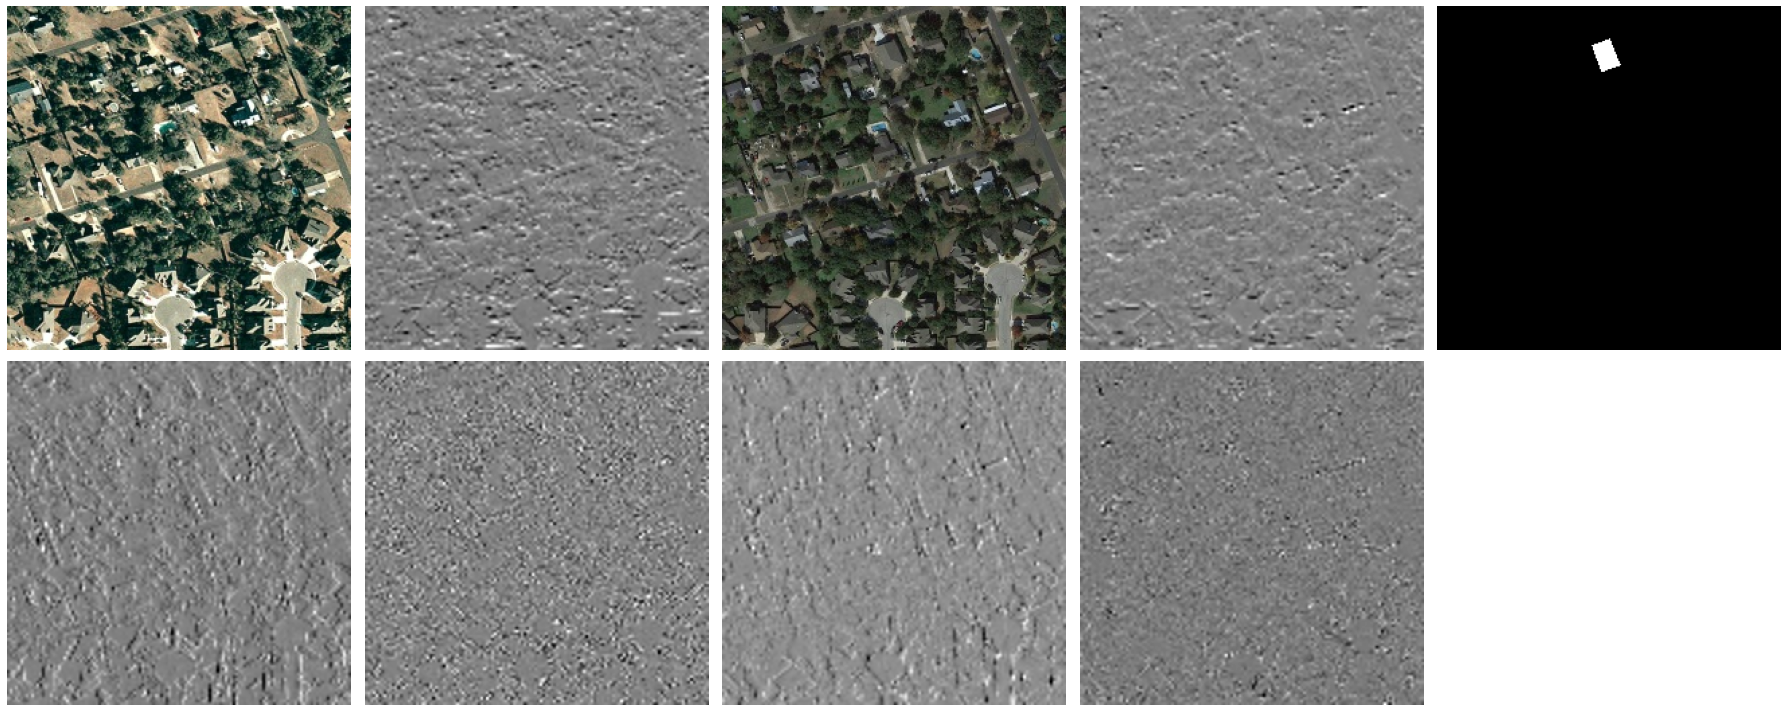

In [ ]:
# Dataset test - mra augmented
for x,y in test_dataset.take(1):
  pass
plt.figure(figsize=(5*5,2*5))
idx = 5
for i, arr in enumerate([x[idx,:,:,:3].numpy(), x[idx,:,:,6].numpy(), x[idx,:,:,3:6].numpy(),
                         x[idx,:,:,9].numpy(), y[idx].numpy().argmax(-1), x[idx,:,:,7].numpy(),
                         x[idx,:,:,8].numpy(), x[idx,:,:,10].numpy(),x[idx,:,:,11].numpy()], start=1):
  plt.subplot(2,5,i)
  plt.imshow(arr,cmap='gray')
  plt.axis('off')
  plt.tight_layout()